In [1]:
# Statistical analysis of PCs as function of cell line and correlation between cell height and experimental factors

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureHeight
Tue May 24 08:34:42 PDT 2022


In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats as spstats
from aicscytoparam import cytoparam
from scipy import cluster as spcluster
from matplotlib import lines as pltlines
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [25]:
df.loc[df.meta_imaging_mode=="Mode C"].FOVId.nunique()

5563

In [18]:
for gene, df_gene in df.groupby("structure_name"):
    df_tmp = df_gene.dropna(subset=[f for f in df.columns if "meta" in f])
    print(f"{gene}\t\t{len(df_gene)}\t{df_gene.FOVId.nunique()}\t{df_tmp.FOVId.nunique()}")

AAVS1		7669	599	574
ACTB		3824	243	219
ACTN1		7653	725	661
ATP2A2		9706	872	807
CETN2		7123	630	579
CTNNB1		5843	658	0
DSP		9798	821	759
FBL		9955	760	685
GJA1		6173	528	496
HIST1H2BJ		15091	1342	1105
LAMP1		10121	952	731
LMNB1		11865	1095	948
MYH10		6205	604	557
NPM1		11827	1009	113
NUP153		16819	1458	1114
PXN		3488	492	453
RAB5A		2411	267	84
SEC61B		6410	523	373
SLC25A17		1853	156	31
SMC1A		2275	245	232
SON		2837	393	293
ST6GAL1		6178	569	491
TJP1		5541	459	425
TOMM20		23062	1963	1117
TUBA1B		9120	730	195


In [5]:
acq_order = ["TUBA1B", "TOMM20", "LMNB1", "DSP", "SEC61B", "ACTB", "ST6GAL1", "MYH10", "TJP1", "FBL", "LAMP1", "CETN2", "GJA1", "AAVS1", "ACTN1", "PXN", "NPM1", "CTNNB1", "RAB5A", "SLC25A17", "HIST1H2BJ", "NUP153", "ATP2A2", "SMC1A", "SON"]

In [6]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [7]:
cmap = plt.cm.get_cmap('Dark2')
workflows = list(df["WorkflowId"].unique())

In [8]:
fprops = {'marker': '.', 'markersize': 5, 'markerfacecolor': 'black', 'markeredgewidth': 0}

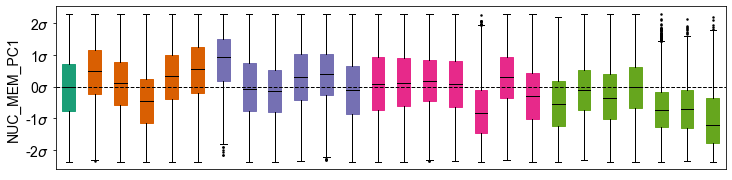

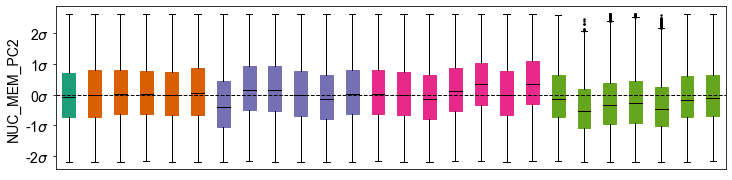

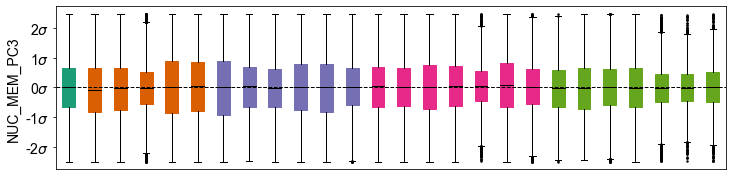

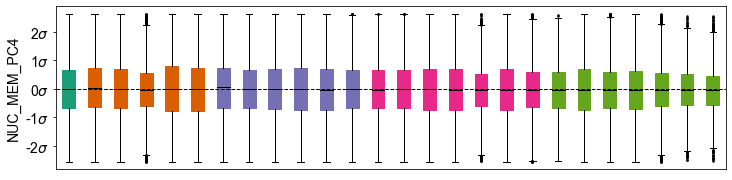

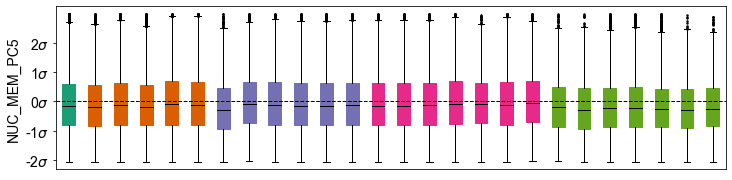

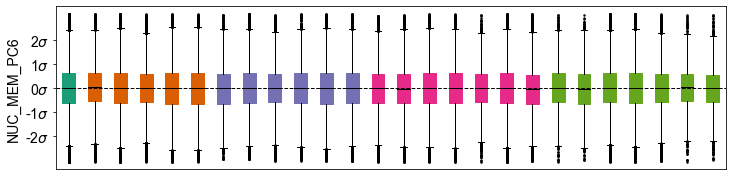

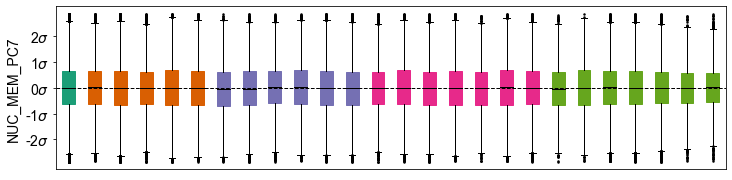

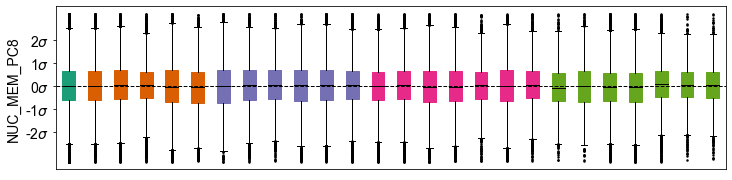

In [9]:
for sm in control.get_shape_modes():
    space.set_active_shape_mode(sm, digitize=True)

    fig, ax = plt.subplots(1,1, figsize=(12,3))
    for gid, gene in enumerate([None]+acq_order):
        idxs = space.shape_modes.index
        if gene is not None:
            idxs = space.shape_modes.loc[(df.structure_name==gene)&df.index.isin(space.shape_modes.index)].index
            workflow = df.at[idxs[0], "WorkflowId"]
        y = space.shape_modes.loc[idxs, sm] / space.get_active_scale()
        box = ax.boxplot(y, positions=[gid], widths=[0.5], patch_artist=True, flierprops=fprops)
        
        wid = 0 if gene is None else 1+workflows.index(workflow)
        plt.setp(box["boxes"], color=cmap(wid))
        plt.setp(box["medians"], color="k")
    ax.axhline(y=0, ls="--", color="k", lw=1)
    sigmas = np.linspace(-2, 2, 5)
    ax.set_yticks(sigmas, [f"{int(s)}$\sigma$" for s in sigmas])
    ax.tick_params(axis="y", which='major', labelsize=14)
    ax.set_ylabel(sm, fontsize=14)
    ax.set_xticks([])
    plt.savefig(f"FigureHeight1_{sm}.pdf", bbox_inches='tight')
    plt.show()

In [10]:
df_plot = df

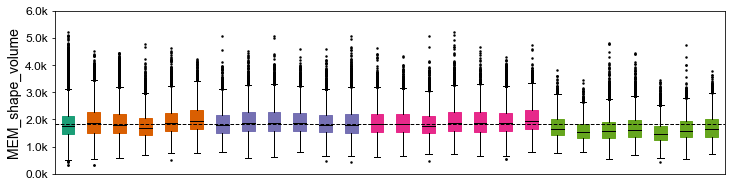

In [11]:
factor = (0.108**3)
varname = "MEM_shape_volume"

fig, ax = plt.subplots(1,1, figsize=(12,3))
for gid, gene in enumerate([None]+acq_order):
    idxs = df_plot.index
    if gene is not None:
        idxs = df_plot.loc[df_plot.structure_name==gene].index
        workflow = df.at[idxs[0], "WorkflowId"]
    y = df_plot.loc[idxs, varname] * factor
    box = ax.boxplot(y, positions=[gid], widths=[0.5], patch_artist=True, flierprops=fprops)

    wid = 0 if gene is None else 1+workflows.index(workflow)
    plt.setp(box["boxes"], color=cmap(wid))
    plt.setp(box["medians"], color="k")
yfull = df_plot[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=12)
ax.set_ylabel(varname, fontsize=14)
ax.set_yticks(ax.get_yticks(), [f"{(t/1e3):.1f}k" for t in ax.get_yticks()])
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Volume.pdf", bbox_inches='tight')
plt.show()

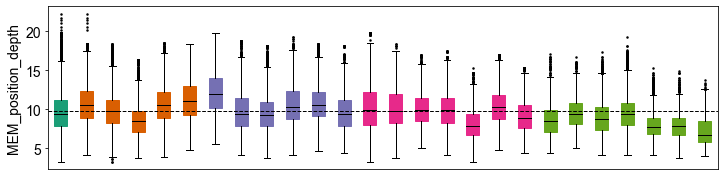

In [12]:
factor = (0.108**1)
varname = "MEM_position_depth"

fig, ax = plt.subplots(1,1, figsize=(12,3))
for gid, gene in enumerate([None]+acq_order):
    idxs = df_plot.index
    if gene is not None:
        idxs = df_plot.loc[df_plot.structure_name==gene].index
        workflow = df.at[idxs[0], "WorkflowId"]
    y = df_plot.loc[idxs, varname] * factor
    box = ax.boxplot(y, positions=[gid], widths=[0.5], patch_artist=True, flierprops=fprops)

    wid = 0 if gene is None else 1+workflows.index(workflow)
    plt.setp(box["boxes"], color=cmap(wid))
    plt.setp(box["medians"], color="k")
yfull = df_plot[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=14)
ax.set_ylabel(varname, fontsize=14)
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Height.pdf", bbox_inches='tight')
plt.show()

In [13]:
cmap = plt.cm.get_cmap('Pastel1')

In [14]:
df_myh10_44 = pd.read_csv("myh10_44.csv", index_col="CellId")
print(df_myh10_44.shape)

(380, 52)


In [15]:
cols = ["MEM_shape_volume", "MEM_position_depth", "WorkflowId"]
df_plot = df.loc[df.structure_name=="MYH10", cols].append(df_myh10_44[cols]).copy()
df_plot.loc[df_plot.WorkflowId!="['Pipeline 4.4']", "MatrigelCoating"] = "original"
df_plot.loc[df_plot.WorkflowId=="['Pipeline 4.4']", "MatrigelCoating"] = "adjusted"
df_plot.groupby("MatrigelCoating", dropna=False).size()

MatrigelCoating
adjusted     380
original    6205
dtype: int64

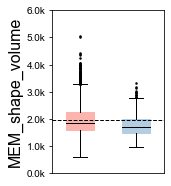

In [16]:
factor = (0.108**3)
varname = "MEM_shape_volume"
fig, ax = plt.subplots(1,1, figsize=(2,3))
for wid, (wk, df_wk) in enumerate(df_plot.groupby("MatrigelCoating", sort=False)):
    y = df_wk[varname] * factor
    box = ax.boxplot(y, positions=[wid], widths=[0.5], patch_artist=True, flierprops=fprops)
    plt.setp(box["boxes"], color=cmap(wid))
    plt.setp(box["medians"], color="k")
    if not wid: 
        yfull = df_wk[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=10)
ax.set_ylabel(varname, fontsize=16)
ax.set_yticks(ax.get_yticks(), [f"{(t/1e3):.1f}k" for t in ax.get_yticks()])
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Volume_adjusted.pdf", bbox_inches='tight')
plt.show()

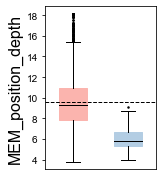

In [17]:
factor = (0.108**1)
varname = "MEM_position_depth"
fig, ax = plt.subplots(1,1, figsize=(2,3))
for wid, (wk, df_wk) in enumerate(df_plot.groupby("MatrigelCoating", sort=False)):
    y = df_wk[varname] * factor
    box = ax.boxplot(y, positions=[wid], widths=[0.5], patch_artist=True, flierprops=fprops)
    plt.setp(box["boxes"], color=cmap(wid))
    plt.setp(box["medians"], color="k")
    if not wid: 
        yfull = df_wk[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=10)
ax.set_ylabel(varname, fontsize=16)
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Height_adjusted.pdf", bbox_inches='tight')
plt.show()

In [18]:
# Matrigel timeline
#                          RAB5A           SMC1A
# |-----------------------|---------------|-----------|
#     Pre-Pipeline 4.4      Old matrigel      New
#                                           matrigel
# *LAMP1 is the only structure imaged before and after RAB5A
#
df["matrigel"] = "Pre-Pipeline 4.4"
df.loc[df.structure_name.isin(acq_order[acq_order.index("RAB5A"):]), "matrigel"] = "Pipeline 4.4, Old matrigel"
df.loc[df.structure_name.isin(acq_order[acq_order.index("SMC1A"):]), "matrigel"] = "Pipeline 4.4, New matrigel"
df.loc[(df.structure_name=="LAMP1")&(df.WorkflowId=="['Pipeline 4.4']"), "matrigel"] = 'Pipeline 4.4, New matrigel'

In [19]:
print(df.groupby(['structure_name','matrigel'], dropna=False).size())
print(df.groupby(['matrigel'], dropna=False).size())

structure_name  matrigel                  
AAVS1           Pre-Pipeline 4.4               7669
ACTB            Pre-Pipeline 4.4               3824
ACTN1           Pre-Pipeline 4.4               7653
ATP2A2          Pipeline 4.4, Old matrigel     9706
CETN2           Pre-Pipeline 4.4               7123
CTNNB1          Pre-Pipeline 4.4               5843
DSP             Pre-Pipeline 4.4               9798
FBL             Pre-Pipeline 4.4               9955
GJA1            Pre-Pipeline 4.4               6173
HIST1H2BJ       Pipeline 4.4, Old matrigel    15091
LAMP1           Pipeline 4.4, New matrigel     1356
                Pre-Pipeline 4.4               8765
LMNB1           Pre-Pipeline 4.4              11865
MYH10           Pre-Pipeline 4.4               6205
NPM1            Pre-Pipeline 4.4              11827
NUP153          Pipeline 4.4, Old matrigel    16819
PXN             Pre-Pipeline 4.4               3488
RAB5A           Pipeline 4.4, Old matrigel     2411
SEC61B          Pre-P

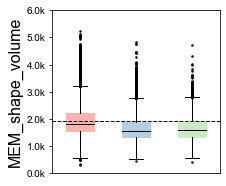

In [20]:
factor = (0.108**3)
varname = "MEM_shape_volume"
fig, ax = plt.subplots(1,1, figsize=(3,3))
for mid, mt in enumerate(["Pre-Pipeline 4.4", "Pipeline 4.4, Old matrigel", "Pipeline 4.4, New matrigel"]):
    df_mt = df.loc[df.matrigel==mt]
    y = df_mt[varname] * factor
    box = ax.boxplot(y, positions=[mid], widths=[0.5], patch_artist=True, flierprops=fprops)
    plt.setp(box["boxes"], color=cmap(mid))
    plt.setp(box["medians"], color="k")
    if not mid: 
        yfull = df_mt[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=10)
ax.set_ylabel(varname, fontsize=16)
ax.set_yticks(ax.get_yticks(), [f"{(t/1e3):.1f}k" for t in ax.get_yticks()])
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Volume_matrigel.pdf", bbox_inches='tight')
plt.show()

In [21]:
y1 = df.loc[df.matrigel=="Pipeline 4.4, New matrigel", varname].values.mean()
y2 = df.loc[df.matrigel=="Pre-Pipeline 4.4", varname].values.mean()
print(f"{100*(1-y1/y2):.2f}%")

13.43%


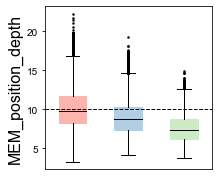

In [22]:
factor = (0.108**1)
varname = "MEM_position_depth"
fig, ax = plt.subplots(1,1, figsize=(3,3))
for mid, mt in enumerate(["Pre-Pipeline 4.4", "Pipeline 4.4, Old matrigel", "Pipeline 4.4, New matrigel"]):
    df_mt = df.loc[df.matrigel==mt]
    y = df_mt[varname] * factor
    box = ax.boxplot(y, positions=[mid], widths=[0.5], patch_artist=True, flierprops=fprops)
    plt.setp(box["boxes"], color=cmap(mid))
    plt.setp(box["medians"], color="k")
    if not mid: 
        yfull = df_mt[varname]*factor
ax.axhline(y=yfull.mean(), ls="--", color="k", lw=1)
ax.tick_params(axis="y", which='major', labelsize=10)
ax.set_ylabel(varname, fontsize=16)
ax.set_xticks([])
plt.savefig(f"FigureHeight1_Height_matrigel.pdf", bbox_inches='tight')
plt.show()

In [23]:
y1 = df.loc[df.matrigel=="Pipeline 4.4, Old matrigel", varname].values.mean()
y2 = df.loc[df.matrigel=="Pre-Pipeline 4.4", varname].values.mean()
print(f"{100*(1-y1/y2):.2f}%")
y1 = df.loc[df.matrigel=="Pipeline 4.4, New matrigel", varname].values.mean()
y2 = df.loc[df.matrigel=="Pre-Pipeline 4.4", varname].values.mean()
print(f"{100*(1-y1/y2):.2f}%")

10.91%
24.85%


In [24]:
common.now("complete")

complete 2022-05-18 21:03:12
